In [1]:
import ray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_cli
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import log_loss
from time import time

In [2]:
def load_drugs_and_targets(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        
    drug_targest = {}
    for line in lines:
        line = line.split()
        drug, targets = line[0][:-1], line[1:]
        
        drug_targest[drug] = set(targets)
    return drug_targest

In [3]:
def transpose(itemsets: dict[str, set]):
    itemsetsT = {}
    for key, items in itemsets.items():
        for item in items:
            itemsetsT.setdefault(item, set()).add(key)
    return itemsetsT

In [4]:
import networkx as nx

def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=G.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

In [5]:
def build_graph_from_dict(item_sets):
    items, sets = item_sets.keys(), item_sets.values()
    items = list(items)
    sets = list(sets)
    
    N = len(items)
    graph = np.zeros((N,N))
    
    for i, s in tqdm(enumerate(sets), total=N):    
        for j in range(i+1, N):
            link_weight = len( s&sets[j] )
            if link_weight!=0:
                graph[i,j]+=link_weight

    return graph+graph.T

In [6]:
def probability(x):
    """
    calculates probability according to bigCLAM definition
    Parameters:
        :x: - Numpy or Number
    """
    return 1 - np.exp(-x)

In [7]:
def random_matrix(shape, min_=0, max_=1):
    """
    Generates a random matrix with values in the range [ {min_}, {max_}]
    Parameters:
        :shape: Tuple or Int indicating the shape of the matrix/Vector
        :min_: Lower Value to be generated in the matrix
        :max_: Highest Value to be generated in the matrix
    """
    return np.random.uniform(low=min_, high=max_, size=shape)

In [8]:
def log_likelihood(fu, f_sum, fv_conns):
    """
    Calculates the log likelihood of a single Node, according to bigCLAM algorithm.
    This implementation uses the 'speed up' in which it is assumed that each node only connects
        to a few of the existing nodes. This speedup pre-computes the summation of the F matrix
        and uses information regarding the neighbors instead of the neighbors, which is a much 
        smaller set of data to process.
    Parameters:
        :fu: Latent Vector of node U
        :f_sum: Sum of Latent Matrix over the community axis
        :fv_conns: Latent Vectos of U neighbors
    """
    prob_conns = probability( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [9]:
@ray.remote
def big_clam_ray(
    F_shape,       # shape of the Latent Matrix, NxK : N-Number of nodes & K-Number of communities  
    conns,         # Dictionary containing the neighborhoods of each node 
    true_graph,    # Adjacency Matrix
    hold_out_idx,  # List of indexes regarding the hold 
    LR,            # Learning Rate
    n_iters,       # Number of iterations
    α,             # Minimum Latent value for any community, to avoid gradient explosion
    MAX_VALUE,     # Maximum Latent value
    stop_threshold  # Minimum percentage improvement treshold for early stopping
):
    """
    Computes bigClam for K communities (Number of columns in F_shape)
    """
    N,K = F_shape
    #initialize F
    F = random_matrix(F_shape)
    nodes = np.arange(N, dtype=int)
    counter=0
    
    f_sum=F.sum(axis=0)
    previous_ll = init_ll = np.array([
        -log_likelihood(F[u], f_sum, F[conns[u]]) for u in nodes
    ]).sum()

    for i in range(n_iters): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)
        current_ll = 0
        
        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = probability(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad
            
            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
            current_ll += log_likelihood(F[u], f_sum, F[conns[u]])
            
        if i%2000 == 0:
            print(f"{K} communities -- iteration {i} finished...")
        
        #check if improvement below 0.001% of previous value, for early stopping
        if np.abs(previous_ll - current_ll) < stop_threshold * np.abs(previous_ll):
            counter+=1
            if counter==5:
                print(f"{K} communities -- Early Stop at iteration {i}...")
                break
        else:
            counter=0
        previous_ll = current_ll
    
    print(f"{K} communities -- Finishing...")
    
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    
    predicted_graph = np.round(
        get_graph_from_communities(F), 
        3
    )
    
    hold_out_ll = log_loss(
        true_graph[hold_out_idx], 
        predicted_graph[hold_out_idx], 
        labels=(0,1)
    )
    
    graph_ll = log_loss(
        true_graph.flatten(), 
        predicted_graph.flatten(),
        labels=(0,1)
    )
    return init_ll, final_ll, hold_out_ll, graph_ll

In [10]:
def run_bigClam(
    N, 
    K_values, 
    connections, 
    true_graph, 
    mask, 
    n_iters=10000,             
    LR=0.00001, 
    max_F=None, 
    α=1e-4,
   stop_threshold=0.001
):
    """
    Computes bigCLAM for different number of communities in parallel using ray.
    
    :Parameters:
        :N:            --> Number of nodes
        :K_values:    --> iterable with the different number of communities to test
        :connections: --> lookup table mapping each node to an iterable with the node connections
        :true_graph:  --> adjacency matrix of the graph
        :mask:        --> binary matrix with 0 in the node positions of the hold_out_set and 1 in the other positions
        :n_iters:     --> number of epochs to estimate the latent matrix
        :LR:          --> learning rate of the model. common values like 0.01 tend to diverge and cause overflows
        :max_F:       --> Max value allowed in the latent matrix
        :α:           --> minimum likelihood considered for a node to belong to a community, to avoid the 0 likelihood
    """
    unmask = (mask+1)%2
    hold_out_idx = np.where(unmask==1)
    
    columns = [
        "initial_log_likelihood", 
        "final_log_likelihood", 
        "hold_edges_log_loss", 
        "adjacency_graph_log_loss"
    ]
    
    results = pd.DataFrame(
        columns = columns
    )
    
    ray_res = []
    for K in K_values:        
        ray_res.append(
            big_clam_ray.remote(
                (N,K),
                conns,  
                true_graph, 
                hold_out_idx, 
                LR=LR, 
                n_iters=n_iters, 
                α=α, 
                MAX_VALUE=max_F,
                stop_threshold=stop_threshold)
        )
    ray_res = ray.get(ray_res)
        
        
    for K, res in zip(K_values, ray_res):        
        results.loc[K] = dict(zip(columns, res))

    return results

In [11]:
def big_clam(conns, F, LR=0.00001, n_iters=1000, α = 1e-8, MAX_VALUE=None, stop_treshold=0.001):
    N,K = F.shape
    nodes = np.arange(N, dtype=int)
    
    f_sum=F.sum(axis=0)
    previous_ll = np.array([
        -log_likelihood(F[u], f_sum, F[conns[u]]) for u in nodes
    ]).sum()
    counter = 0
    
    for i in tqdm(range(n_iters)): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)
        current_ll=0
        
        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = probability(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad
                        
            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
            current_ll += log_likelihood(F[u], f_sum, F[conns[u]])
        
        if np.abs(previous_ll - current_ll) < stop_treshold * np.abs(previous_ll):
            counter+=1
            if counter==5:
                print("Early Stop")
                break
        else:
            counter=0
        previous_ll = current_ll
            
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    return final_ll

In [12]:
def get_communities(F, thresh):
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [13]:
def get_graph_from_communities(F):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = probability(F[i]@F[j])
    
    return graph

In [14]:
def get_weighted_graph_from_communities(F, thresh):
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                for c in range(k):
                    if probability(F[i,c] * F[j, c])>thresh:
                        graph[i,j]+=1
                
    return graph

# Load Data and build the Drug-Drug Graph
- edges represent shared targets

In [15]:
drugs = load_drugs_and_targets("acts.txt")
n_drugs = len(drugs)
n_targets = len(transpose(drugs))
print("number of nodes: ", n_drugs)
print("number of targets: ", n_targets)

number of nodes:  1101
number of targets:  1244


In [16]:
drugs_graph = build_graph_from_dict(drugs)

  0%|          | 0/1101 [00:00<?, ?it/s]

In [18]:
G = nx.Graph()
G.add_nodes_from(range(n_drugs))
G.add_edges_from( np.argwhere(drugs_graph!=0) )

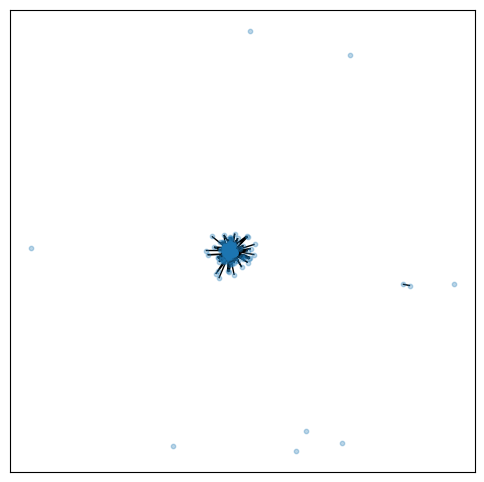

In [20]:
plot_graph(G)

## Big Clam

- Hold out set de **Edges** 20% - verificar se o algoritmo consegue reconstruir as ligações eliminadas
- Avaliar os resultados através da cross-entropy entre a previsão e a matriz original
- Como descrito no algoritmo original do bigClam, o número de comunidades é selecionado a partir do resultado da avaliação no hold out set

In [17]:
NN = drugs_graph.shape[0]

In [42]:
α = 1e-4
δ = np.sqrt(-np.log(1 - np.argwhere(drugs_graph!=0).shape[0] / (NN * (NN-1))))
δ

0.7289681920869288

In [19]:
node_pairs = set(
    list(
        map(lambda x: tuple(sorted(x)), np.argwhere(drugs_graph!=0))
    )
)

In [20]:
node_pairs = np.array(
    list(map(list, node_pairs))
)

In [21]:
node_pairs.shape

(249617, 2)

In [22]:
#select the 20% edges to remove
N_out = int(len( node_pairs ) * 0.2)
node_pairs_idx = np.arange(len(node_pairs), dtype=int)

np.random.seed(1)
hold_out_idx = np.random.choice(node_pairs_idx, size=N_out, replace=False)

mask = np.ones(drugs_graph.shape)
for idx in hold_out_idx:
    i,j = node_pairs[idx]
    mask[i,j]=mask[j,i]=0
unmask=(mask+1)%2

In [23]:
#remove the edges in the graph used for training
drugs_graph_train = drugs_graph.copy()*mask

In [24]:
(drugs_graph_train>0).sum()//2

199694

In [25]:
conns = {
    i : np.where(node_conns!=0)[0] for i, node_conns in enumerate(drugs_graph_train)
}

In [26]:
ray.init()

2023-06-08 20:30:26,786	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.4.0


In [27]:
ks = [2<<i for i in range(7, 0, -1)]
bc_results = run_bigClam(
    NN, 
    ks, 
    conns, 
    (drugs_graph>0)*1,
    mask=mask,
    n_iters=20000,
    LR=0.00001,
    stop_threshold=0.00001
)

(big_clam_ray pid=31100) 32 communities -- iteration 0 finished...
(big_clam_ray pid=31100) 32 communities -- iteration 2000 finished... [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(big_clam_ray pid=3352) 64 communities -- iteration 2000 finished...
(big_clam_ray pid=31100) 32 communities -- iteration 4000 finished...
(big_clam_ray pid=24072) 128 communities -- iteration 2000 finished...
(big_clam_ray pid=3352) 64 communities -- iteration 4000 finished...
(big_clam_ray pid=31100) 32 communities -- Early Stop at iteration 5717...
(big_clam_ray pid=31100) 32 communities -- Finishing...
(big_clam_ray pid=31100) 16 communities -- iteration 0 finished...
(big_clam_ray pid=31100) 16 communities -- iteration 2000 finished...
(big_clam_ray pid=3352) 64 communities -- iteration 6000 finished...
(big_clam_ray pid=24072

In [28]:
ray.shutdown()

In [29]:
bc_results.sort_values("hold_edges_log_loss")

,initial_log_likelihood,final_log_likelihood,hold_edges_log_loss,adjacency_graph_log_loss
64,1.295627e+07,291160.214647,0.373759,0.151944
128,2.599343e+07,281074.947090,0.381138,0.147463
256,5.188450e+07,263732.725416,0.391412,0.137661
32,6.493065e+06,316664.691252,0.398400,0.176056
16,3.290313e+06,324032.103328,0.406824,0.181992
8,1.716282e+06,352798.663877,0.447032,0.212617
4,1.048042e+06,379488.319605,0.482439,0.244551


We can see that the number of communities that resulted in a lower log loss in the hold out edges is 64, with small difference in the final log likelihood.

In [31]:
#bc_results.to_csv("big_clam_K_results.csv", index=True)

In [27]:
k=64
MAX = None
F = random_matrix((NN, k))

ll_i=np.array(
    [-log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(F.shape[0])]
).sum()
print("Initial Evaluation: ", ll_i)

Initial Evaluation:  12895818.862622857


In [28]:
ll_f = big_clam(conns, F, LR=0.00001, n_iters=15000, α=α, MAX_VALUE=MAX, stop_treshold=0.00001)
print("Final Evaluation: ", ll_f)

  0%|          | 0/15000 [00:00<?, ?it/s]

Early Stop
Final Evaluation:  305155.1363160456


In [29]:
#F = np.load("bc_64c.npy")

In [39]:
#np.save("bc_64c.npy", F)

In [41]:
np.argwhere(drugs_graph!=0).shape[0] / (NN * (NN-1))

0.4122153414251507

In [96]:
δ

0.010000250013542027

In [29]:
np.round(F, 3)

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.164, 0.   , 0.   , ..., 0.367, 0.   , 0.157],
       ...,
       [0.531, 0.   , 0.   , ..., 0.   , 0.   , 0.312],
       [0.   , 0.   , 0.611, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [30]:
list(map(len, get_communities(F, δ).values()))

[416,
 345,
 273,
 331,
 347,
 215,
 268,
 367,
 229,
 398,
 273,
 349,
 433,
 417,
 370,
 361,
 430,
 366,
 258,
 253,
 179,
 305,
 408,
 254,
 255,
 241,
 183,
 302,
 197,
 407,
 388,
 337,
 271,
 430,
 425,
 253,
 398,
 448,
 283,
 325,
 441,
 344,
 476,
 420,
 460,
 369,
 374,
 137,
 455,
 322,
 423,
 368,
 458,
 389,
 274,
 248,
 447,
 430,
 375,
 277,
 358,
 387,
 340,
 392]

In [31]:
temp = get_graph_from_communities(F)
temp = np.round(temp, 3)

In [32]:
temp

array([[0.   , 0.   , 0.001, ..., 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.001, ..., 0.001, 0.   , 0.   ],
       [0.001, 0.001, 0.   , ..., 0.734, 0.001, 0.001],
       ...,
       [0.001, 0.001, 0.734, ..., 0.   , 0.001, 0.733],
       [0.   , 0.   , 0.001, ..., 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.001, ..., 0.733, 0.   , 0.   ]])

In [33]:
idx=np.where(unmask==1)
idx

(array([   0,    0,    0, ..., 1100, 1100, 1100], dtype=int64),
 array([  53,   62,   75, ..., 1087, 1094, 1098], dtype=int64))

In [34]:
log_loss(
    (drugs_graph[idx]>0)*1,
    temp[idx],
    labels=(0,1)
)

0.3896904677048544

In [35]:
log_loss(
    ((drugs_graph>0)*1).flatten(), 
    np.ones(np.prod(drugs_graph.shape))
)

21.199401275760934

In [37]:
log_loss(
    ((drugs_graph>0)*1).flatten(), 
    random_matrix(np.prod(drugs_graph.shape))
)

0.9992154228982879

In [38]:
log_loss(
    ((drugs_graph>0)*1).flatten(),
    temp.flatten()
)

0.1666084257674964